In [ ]:
import os
import json
import csv
import cv2
import numpy as np

# -------------------------------------------------------
# 路徑設定（依照目前 final_proposol_02 版）
# -------------------------------------------------------
JSON_PATH      = "/home/rick/deepLearning/final_proposol_02/data/val2017_prompt.json"
GT_MASK_DIR    = "/home/rick/deepLearning/final_proposol_02/data/maskval2017_50"      
PRED_MASK_DIR  = "/home/rick/deepLearning/final_proposol_02/outputs/sam_text_clip_patch"
RESULTS_DIR    = "/home/rick/deepLearning/final_proposol_02/results"

os.makedirs(RESULTS_DIR, exist_ok=True)

prompt_levels = ["coarse", "attribute", "fine_grained"]

print("JSON_PATH exists?     ", os.path.exists(JSON_PATH))
print("GT_MASK_DIR exists?   ", os.path.exists(GT_MASK_DIR))
print("PRED_MASK_DIR exists? ", os.path.exists(PRED_MASK_DIR))
print("RESULTS_DIR:          ", RESULTS_DIR)

# -------------------------------------------------------
# 1. 讀取並二值化 mask 的工具函式
# -------------------------------------------------------
def load_binary_mask(path, target_shape=None):
    """
    讀灰階圖，轉成 0/1 的 numpy 陣列。
    如果 target_shape 給定，會用最近鄰插值 resize 成相同大小。
    """
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    if mask is None:
        raise FileNotFoundError(path)

    if target_shape is not None and mask.shape != target_shape:
        mask = cv2.resize(mask, (target_shape[1], target_shape[0]), interpolation=cv2.INTER_NEAREST)

    # >0 當成前景
    mask_bin = (mask > 0).astype(np.uint8)
    return mask_bin


def find_gt_mask_path(base):
    """
    嘗試多種命名規則找 ground-truth mask：
      base.png / base.jpg / base_mask.png / base_mask.jpg
    找到第一個就回傳，否則回傳 None。
    """
    candidates = [
        os.path.join(GT_MASK_DIR, f"{base}.png"),
        os.path.join(GT_MASK_DIR, f"{base}.jpg"),
        os.path.join(GT_MASK_DIR, f"{base}_mask.png"),
        os.path.join(GT_MASK_DIR, f"{base}_mask.jpg"),
    ]
    for p in candidates:
        if os.path.exists(p):
            return p
    return None


def compute_metrics(gt, pred):
    """
    給兩張 0/1 mask，回傳 IoU / Precision / Recall / Dice
    """
    gt = gt.astype(bool)
    pred = pred.astype(bool)

    inter = np.logical_and(gt, pred).sum()
    union = np.logical_or(gt, pred).sum()
    pred_sum = pred.sum()
    gt_sum = gt.sum()

    iou = inter / union if union > 0 else 0.0
    precision = inter / pred_sum if pred_sum > 0 else 0.0
    recall = inter / gt_sum if gt_sum > 0 else 0.0
    denom = pred_sum + gt_sum
    dice = (2 * inter / denom) if denom > 0 else 0.0

    return iou, precision, recall, dice


# -------------------------------------------------------
# 2. 主流程：對 50 張圖 × 3 prompt level 計算指標
# -------------------------------------------------------
def compute_clip_sam_vs_gt_metrics():
    print("\n=== Compute CLIP-guided SAM vs GT metrics ===")
    with open(JSON_PATH, "r", encoding="utf-8") as f:
        items = json.load(f)
    print("Loaded JSON items:", len(items))

    detail_rows = []  # 每張圖像 × 每個 prompt_level 一筆
    missing_gt = 0
    missing_pred = 0

    for item in items:
        image_name = item["image_filename"]
        base = os.path.splitext(image_name)[0]

        # 找 GT mask
        gt_path = find_gt_mask_path(base)
        if gt_path is None:
            print(f" Missing GT mask for image {image_name}")
            missing_gt += 1
            continue

        try:
            # 先讀 GT，一會兒當作 pred 的 target_shape
            gt_mask = load_binary_mask(gt_path)
        except FileNotFoundError:
            print(f" Cannot read GT mask: {gt_path}")
            missing_gt += 1
            continue

        for level in prompt_levels:
            pred_mask_path = os.path.join(
                PRED_MASK_DIR,
                f"{base}_{level}_clip_sam_mask.png"
            )

            if not os.path.exists(pred_mask_path):
                print(f" Missing pred mask: {pred_mask_path}")
                missing_pred += 1
                continue

            pred_mask = load_binary_mask(pred_mask_path, target_shape=gt_mask.shape)

            iou, prec, rec, dice = compute_metrics(gt_mask, pred_mask)

            detail_rows.append({
                "id": item["id"],
                "image_filename": image_name,
                "primary_category": item.get("primary_category", ""),
                "prompt_level": level,
                "gt_mask_path": gt_path,
                "pred_mask_path": pred_mask_path,
                "IoU": iou,
                "Precision": prec,
                "Recall": rec,
                "Dice": dice,
            })

    # 2-1. 寫出詳細結果
    detail_csv = os.path.join(RESULTS_DIR, "clip_sam_vs_gt_metrics_detail.csv")
    with open(detail_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=[
                "id", "image_filename", "primary_category",
                "prompt_level", "gt_mask_path", "pred_mask_path",
                "IoU", "Precision", "Recall", "Dice"
            ]
        )
        writer.writeheader()
        writer.writerows(detail_rows)

    print(f"\n✅ Detail metrics saved to: {detail_csv}")
    print("Total evaluated rows:", len(detail_rows))
    print("Missing GT masks:", missing_gt, "| Missing pred masks:", missing_pred)

    # 2-2. 做簡單 summary：依 prompt_level 算平均 可拿來畫表
    summary = {}
    for row in detail_rows:
        lvl = row["prompt_level"]
        if lvl not in summary:
            summary[lvl] = {"cnt": 0, "IoU": 0.0, "Precision": 0.0, "Recall": 0.0, "Dice": 0.0}
        summary[lvl]["cnt"] += 1
        summary[lvl]["IoU"] += row["IoU"]
        summary[lvl]["Precision"] += row["Precision"]
        summary[lvl]["Recall"] += row["Recall"]
        summary[lvl]["Dice"] += row["Dice"]

    summary_rows = []
    for lvl, agg in summary.items():
        c = max(agg["cnt"], 1)
        summary_rows.append({
            "prompt_level": lvl,
            "count": agg["cnt"],
            "IoU_mean": agg["IoU"] / c,
            "Precision_mean": agg["Precision"] / c,
            "Recall_mean": agg["Recall"] / c,
            "Dice_mean": agg["Dice"] / c,
        })

    summary_csv = os.path.join(RESULTS_DIR, "clip_sam_vs_gt_metrics_summary.csv")
    with open(summary_csv, "w", newline="", encoding="utf-8") as f:
        writer = csv.DictWriter(
            f,
            fieldnames=["prompt_level", "count", "IoU_mean", "Precision_mean", "Recall_mean", "Dice_mean"]
        )
        writer.writeheader()
        writer.writerows(summary_rows)

    print(f"✅ Summary metrics saved to: {summary_csv}")
    print("\nSummary:")
    for row in summary_rows:
        print(row)


# 直接跑
compute_clip_sam_vs_gt_metrics()


JSON_PATH exists?      True
GT_MASK_DIR exists?    True
PRED_MASK_DIR exists?  True
RESULTS_DIR:           /home/rick/deepLearning/final_proposol_02/results

=== Compute CLIP-guided SAM vs GT metrics ===
Loaded JSON items: 50

✅ Detail metrics saved to: /home/rick/deepLearning/final_proposol_02/results/clip_sam_vs_gt_metrics_detail.csv
Total evaluated rows: 150
Missing GT masks: 0 | Missing pred masks: 0
✅ Summary metrics saved to: /home/rick/deepLearning/final_proposol_02/results/clip_sam_vs_gt_metrics_summary.csv

Summary:
{'prompt_level': 'coarse', 'count': 50, 'IoU_mean': np.float64(0.07607068889034804), 'Precision_mean': np.float64(0.3342988395583478), 'Recall_mean': np.float64(0.08378828964832173), 'Dice_mean': np.float64(0.10809852487161616)}
{'prompt_level': 'attribute', 'count': 50, 'IoU_mean': np.float64(0.12384809378234277), 'Precision_mean': np.float64(0.38016272976783766), 'Recall_mean': np.float64(0.13212649326663012), 'Dice_mean': np.float64(0.1610138074851228)}
{'prompt

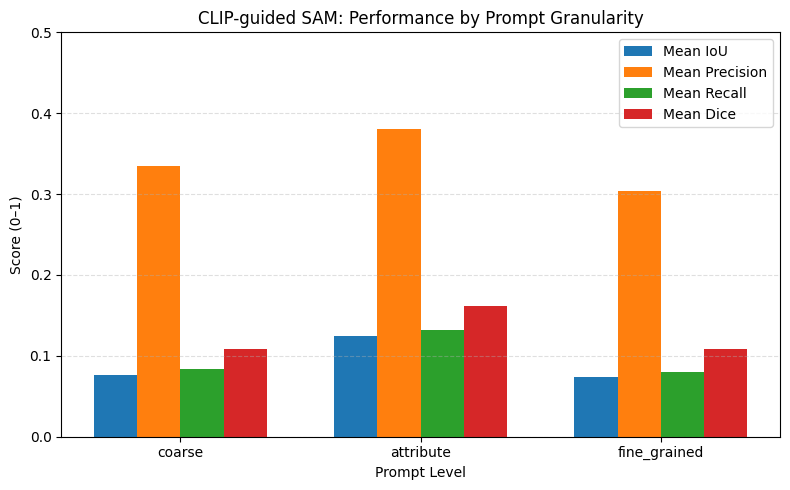

In [ ]:
import matplotlib.pyplot as plt

# 三種 prompt 粒度
labels = ["coarse", "attribute", "fine_grained"]

# SAM+CLIP 結果（summary CSV 裡的平均值）
mean_iou = [
    0.07607068889034804,
    0.12384809378234277,
    0.07368698610436479,
]
mean_precision = [
    0.3342988395583478,
    0.38016272976783766,
    0.3032616706488416,
]
mean_recall = [
    0.08378828964832173,
    0.13212649326663012,
    0.08049118999726967,
]
mean_dice = [
    0.10809852487161616,
    0.1610138074851228,
    0.1080246880937712,
]

x = np.arange(len(labels))  # 粒度 index
width = 0.18                 # 每個 bar 的寬度

fig, ax = plt.subplots(figsize=(8, 5))

ax.bar(x - 1.5*width, mean_iou,       width, label="Mean IoU")
ax.bar(x - 0.5*width, mean_precision, width, label="Mean Precision")
ax.bar(x + 0.5*width, mean_recall,    width, label="Mean Recall")
ax.bar(x + 1.5*width, mean_dice,      width, label="Mean Dice")

ax.set_xlabel("Prompt Level")
ax.set_ylabel("Score (0–1)")
ax.set_title("CLIP-guided SAM: Performance by Prompt Granularity")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.set_ylim(0.0, 0.5)   # 數值大概落在 0~0.4，多留一點空間
ax.legend(loc="upper right")
ax.grid(axis="y", linestyle="--", alpha=0.4)

plt.tight_layout()
plt.show()


確認輸出圖是否沒依照prompt多粒度產生差異 

In [ ]:
base = "000000006954"  # id
root = "/home/rick/deepLearning/final_proposol_02/outputs/sam_text_clip_patch"

paths = {
    "coarse":      f"{root}/{base}_coarse_clip_sam_mask.png",
    "attribute":   f"{root}/{base}_attribute_clip_sam_mask.png",
    "fine_grained":f"{root}/{base}_fine_grained_clip_sam_mask.png",
}

masks = {k: cv2.imread(p, cv2.IMREAD_GRAYSCALE) for k, p in paths.items()}

print("shape:", {k: m.shape for k, m in masks.items()})
print("coarse vs attribute diff pixels:", np.sum(masks["coarse"] != masks["attribute"]))
print("coarse vs fine diff pixels:",     np.sum(masks["coarse"] != masks["fine_grained"]))
print("attribute vs fine diff pixels:",  np.sum(masks["attribute"] != masks["fine_grained"]))


shape: {'coarse': (480, 640), 'attribute': (480, 640), 'fine_grained': (480, 640)}
coarse vs attribute diff pixels: 44384
coarse vs fine diff pixels: 1236
attribute vs fine diff pixels: 45122
